In [1]:
%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os

matplotlib.style.use('ggplot')

comp_name=socket.gethostname()
if  comp_name == 'Ezequiels-MacBook-Pro.local':
    print 'Computer: ' + comp_name
    sys.path.append('/Users/zeke/experiment/ephysDataManagement/ephysScripts')
    experiment_folder = os.path.join('/Users','zeke','experiment')
else:
    print 'Computer: ' + 'server'
    sys.path.append('/experiment/ephysDataManagement/ephysScripts')
    experiment_folder = os.path.join('/','experiment')
    
import unitToolsv2
from data_handling import ephys_names as en

Computer: server


In [2]:
#fucntions for handling and plotting
def decim(x, q):
    #decimate a 1 x n array
    #x: 1xn matrix (float)
    #q: int (decimate ratio), 0<q<=x.size
    assert(x.size>=q and q>0)
    pad_size = math.ceil(float(x.size)/q)*q - x.size
    pad = np.empty(pad_size)
    pad[:]=np.nan
    x_padded = np.append(x,pad)
    return sp.nanmean(x_padded.reshape(-1,q),axis=1)

def plot_raster(x, t1=0, t2=-1, t0=0, ax=None, bin_size=0):
    #plot a raster
    #x: spikes matrix:
        # nxt matrix with 1 where there is a spikes.
        # cols: time stamps (ms)
        # rows: trials
       
    #t1 from beggining of x to plot: default 0, dont cut
    #t2 time after begginning of x to plot: default -1, all range
    #t0 where to put the 0 (stimulus mark) relative to the range t1:t2
    #ax: axes object where to put the plot in (default = None, create a new one)
    #bin_size: int
    
    #Returns:
    # raster: a PathCollection (if bin_size=0) or a Line2D object (if bin_size=1)
    # ax    : Axes object 
    
    # Chop the segment
    if t2>0:
        assert(t2>t1)
        x = x[:,t1:t2]
    else:
        x = x[:,t1:]
            
    # get dimensions and time
    events   = x.shape[0]
    t_stamps = x.shape[1]
    t=np.arange(t_stamps)-t0
    
    #prepare the axis
    # if no axis, make a new plot
    if ax is None:
            raster_fig = plt.figure()
            ax = raster_fig.add_axes([0, 0, 1, 1])


    #pdb.set_trace()
    #if bin_size was entered, we want a psth
    if bin_size > 0:
        base_line = decim(np.mean(x[:t_stamps,:],axis=0), bin_size)/(0.001*bin_size)
        t_dec     = decim(t, bin_size);
        raster    = ax.plot(t_dec,base_line)
        
        ax.set_ylim(0, max(base_line)*1.2)
        stim   = ax.plot((0,0),(0,max(base_line)*1.2),'k--')
    
    else:
        #mask the zeros (no spike)
        nsp = x[:] == 0
        #x[nsp]=np.nan    
        
        
        #make the frame for plotting
        row = np.ones(t_stamps, dtype=np.float)
        col = np.arange(events, dtype=np.float)
        frame = col[:,np.newaxis] + row[np.newaxis,:]
        
        raster = ax.scatter(t*x,frame*x,marker='|')
        ax.set_ylim(0, events+1)
        stim   = ax.plot((0,0),(0,events+1),'k--')
        
    
    ax.set_xlim(0-t0,t_stamps-t0)
    
    return raster, ax

In [42]:
#functions for getting units
#Load a baseline sniff file
def load_sniff_base(mat_file_path, as_dict=True):
    assert(os.path.isfile(mat_file_path))
    #print sio.whosmat(mat_file)
    base_data = sio.loadmat(mat_file_path,struct_as_record=False, squeeze_me=True)

    #print type(cell_data['raster'])
    #print len(cell_data['raster'])
    #num_recs = len(cell_data['raster']) #num of recs the cell spans

    if type(base_data['trialsBase']) == np.ndarray:
        trialsBase = base_data['trialsBase']
    else:
        #there is only one trial!
        #this is bad; but I will debug later.
        #for now just make a list with the only trial
        trialsBase = np.array([base_data['trialsBase']])
   
    
    #print trialsBase[0].sniffFlow
    num_trials = trialsBase.shape[0]
    num_tpoints = trialsBase[0].sniffFlow.shape[0]
    #print num_trials

    sniff_flow = np.empty([num_tpoints, num_trials],dtype=int)
    sniff_phase = np.empty([num_tpoints, num_trials],dtype=int)
    sniff_start = np.empty([num_trials,1],dtype=int)
    #print sniff_flow.shape

    for i in range(num_trials):
        #print i
        tb=trialsBase[i]
        sniff_flow[:,i]  = tb.sniffFlow
        sniff_phase[:,i] = tb.sniffPhase[0:(num_tpoints)]
        sniff_start[i] = tb.start

    #print tb.sniffFlow.shape
    #print sniff_start
    #print tb['start'][0][0]
    #print tb['trialUId'][0]
    
    #get the rec_id from the file_name
    rec_id = os.path.split(mat_file_path)[-1].split('trialsBase.mat')[0][:-1]
    
    sniffs={ 'flow'      : sniff_flow,
             'phase'     : sniff_phase,
             'start'     : sniff_start,
             'trial_uid' : [str(x.trialUId) for x in trialsBase],
             'rec_id'    : rec_id
           }
    
    if as_dict:
        return {rec_id : sniffs}
    else:
        return sniffs

#Load a baseline raster file
def get_baseline(spikesBase):
    num_trials = spikesBase.spikes.shape[0]
    #print 'numtrials ' + str(num_trials)
    num_tpoints = spikesBase.spikes.shape[0]
    #print 'numpoints ' + str(num_tpoints)
    
    #sr_spikes = np.array(spikesBase.spikes, dtype=np.float)
    #sr_t0     = np.array(spikesBase.t0, dtype = np.float)
    
    base_spikes = { 'spikes' : np.array(spikesBase.spikes, dtype=np.float),
                    't_0'    : np.array(spikesBase.t0, dtype = np.float),
                    'mouse ' : str(spikesBase.mouse),
                    'sess'   : spikesBase.sess,
                    'rec'    : str(spikesBase.rec),
                    'u_id'   : str(spikesBase.uid),
                    'id'     : str(spikesBase.cellId),
                    'rec_id' : str(spikesBase.mouse) + '_' + str(spikesBase.sess).zfill(3) + '_' + str(spikesBase.rec)
                   }
    
    return base_spikes

#Load a baseline raster file
def load_baseline(mat_file_path, as_dict = True):
    
    assert(os.path.isfile(mat_file_path))
    base_data = sio.loadmat(mat_file_path,struct_as_record=False,squeeze_me = True)

    baselines = {}
    if type(base_data['spikesBase']) == np.ndarray:
        for base in  base_data['spikesBase']:
            #print rec
            baseline = get_baseline(base)
            baselines[baseline['id']] = baseline
    else:
        baseline = get_baseline(base_data['spikesBase'])
        baselines[baseline['id']] = baseline
    
    if as_dict:
        return baselines
    else:
        baselines_list = [baselines[a_key] for a_key in baselines.keys()]
        return baselines_list

# load trials file
def load_trials(mat_file_path, as_dict = True):
    assert(os.path.isfile(mat_file_path))
    trial_data = sio.loadmat(mat_file_path, struct_as_record=False, squeeze_me=True)

    trials     = { 'rec_id'     : str(trial_data['mouse'] + '_' + str(trial_data['sess']).zfill(3) + '_' + trial_data['rec']),
                   'mouse'      : str(trial_data['mouse']),
                   'rec'        : str(trial_data['rec']),
                   'sess'       : trial_data['sess'],
                   'start'      : [x.start for x in trial_data['trial']],
                   'odor'       : [str(x.odorName) for x in trial_data['trial']],
                   'odor_c'     : [x.odorConc for x in trial_data['trial']],
                   'odor_t'     : [x.odorTimes for x in trial_data['trial']],
                   'sniff_flow' : [x.flow for x in trial_data['trial']],
                   'sniff_zero' : [x.sniffZeroTimes for x in trial_data['trial']]
                  }
    if as_dict:
        return {trials['rec_id'] : trials}
    else:
        return trials

#get a record from a matlab struct of a cell
def get_rec(rec):
    cell_data = rec.cell
    cell_odor_resp = {'odors'  : [ str(t) for t in rec.odors],
                      'trialId': [ str(t) for t in rec.trialId],
                      'concs'  : [ t for t in rec.concs],
                      'spikes' : np.array(rec.spikes, dtype=np.float),
                      't_0'    : np.array(rec.t0, dtype = np.float)
                      }
    #print cell_meta                  
    cell_meta ={'light'    : cell_data.light,
                'odor'     : cell_data.odor,
                'quality'  : cell_data.quality,
                'sessCell' : cell_data.sessCell,
                'mouse'    : str(cell_data.mouse),
                'sess'     : cell_data.sess,
                'rec'      : str(cell_data.rec),
                'u_id'     : str(cell_data.uId),
                'id'       : str(cell_data.Id),
                'comment'  : str(cell_data.comment)
                }

    record = {'meta'       : cell_meta,
              'odor_resp'  : cell_odor_resp,
              'light_resp' : '',
              'rec_id'     : cell_meta['mouse'] + '_' + str(cell_meta['sess']).zfill(3) + '_' + cell_meta['rec']
              }
    return record

#Load a record (cell file)
def load_cell(mat_file_path):
    assert(os.path.isfile(mat_file_path))
    cell_data = sio.loadmat(mat_file_path, struct_as_record=False, squeeze_me=True)

    records = []
    #print type(cell_data['raster'])
    #print len(cell_data['raster'])
    #num_recs = len(cell_data['raster']) #num of recs the cell spans

    if type(cell_data['raster']) == np.ndarray:
        for rec in  cell_data['raster']:
            #print rec
            record = get_rec(rec)
            records.append(record)
    else:
        records.append(get_rec(cell_data['raster']))
    
    return records

#Load a unit file
def load_unit(mat_file_path, as_dict=True):
    assert(os.path.isfile(mat_file_path))
    unit_data   = sio.loadmat(mat_file_path, struct_as_record=False, squeeze_me=True)
    unit_struct = unit_data['unit']
    
    #get the rec_id from the file_name
    rec_id = os.path.split(mat_file_path)[-1].split('spikes.mat')[0][:-1]
    
    unit       = {'rec_id'     : rec_id,
                  'mouse'      : rec_id.split('_')[0],
                  'rec'        : rec_id.split('_')[1],
                  'sess'       : int(float(rec_id.split('_')[1])),
                  'u_id'       : str(unit_struct.uId),
                  'chans'      : np.array(unit_struct.chans, dtype=np.int),
                  'times'      : np.array(unit_struct.times, dtype=np.float),
                  'pk_stamps'  : np.array(unit_struct.pkStamps, dtype=np.float),
                  'clu'        : unit_struct.clu,
                  'sites'      : [str(x) for x in unit_struct.sites],
                  'sess_cell'  : unit_struct.sessCell,
                  'id'         : rec_id + '_' + str(unit_struct.sessCell).zfill(3)
                  }
    if as_dict:
        return {unit['id'] : unit}
    else:
        return unit

In [4]:
mouse = 'ZKawakeM72'
sess  = 27
rec   = 'a'
fn = en.file_names(mouse,sess,rec,root=experiment_folder)

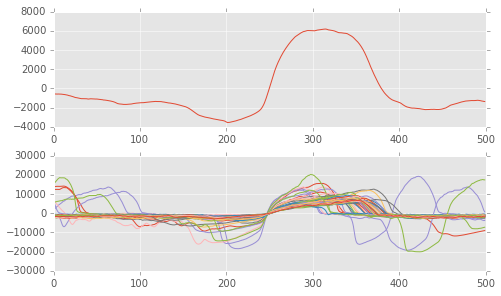

In [121]:
#Load a baseline sniff file
mat_file = os.path.join(fn.fold_exp_data,'ZKawakeM72_027_e_trialsBase.mat')

sniffs= load_sniff_base(mat_file, as_dict=False)
#plot all the baseline sniffs
snif_plot = plt.figure()
all_ax = snif_plot.add_axes([0, 0, 1, .4])
avg_ax = snif_plot.add_axes([0, .5, 1, .4])

t=np.arange(0, 450, 1)
avg_line = avg_ax.plot(np.average(-sniffs['flow'][250:750,:],axis=1))
lines=all_ax.plot(-sniffs['flow'][250:750,:50])

['ZKawakeM72_010_c_001', 'ZKawakeM72_010_b_001']


(-500, 2500)

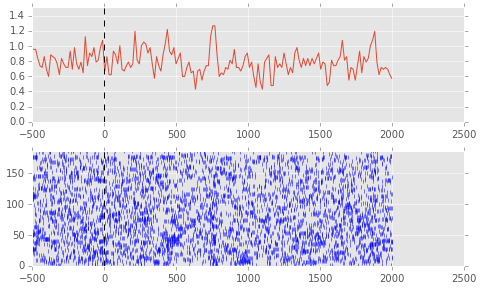

In [7]:
#load the spikes baseline raster file
'ZKawakeM72_010_001_cell.mat'
mat_file = os.path.join(fn.fold_exp_data,'ZKawakeM72_010_001_spikesBase.mat')

bases = load_baseline(mat_file)
print bases.keys()
spikes = [bases[a_key] for a_key in bases.keys()]

#spikes = load_baseline(mat_file, as_dict = False)
#print spikes
#print spikes[0]['u_id']
#print spikes[0]['id']

sr_spikes = spikes[0]['spikes']
sr_t0 = spikes[0]['t_0']

#plot all the baseline sniffs
sr_plot = plt.figure()
ras_ax  = sr_plot.add_axes([0, 0, 1, .4])
hist_ax = sr_plot.add_axes([0, .5, 1, .4])
t0 = 500
t1 = 0
t2= 2500
bin_size=10

#plot the raster
lines,_ = plot_raster(sr_spikes,t0=t0,t1=t1,t2=t2,ax=ras_ax)
ras_ax.set_xlim(-500,2500)

#the psth
hist_line, hist_ax = plot_raster(sr_spikes,t0=t0, t1=t1,t2=t2, bin_size=15, ax=hist_ax)
#hist_ax.set_ylim(0.9,1.1)
hist_ax.set_xlim(-500,2500)

In [49]:
#get the units metadata

mat_file = os.path.join(fn.fold_exp_data,'unitsmeta.mat')
print sio.whosmat(mat_file)
cell_array = sio.loadmat(mat_file,struct_as_record=False)
print cell_array['cellsArray'].shape
n_cells = cell_array['cellsArray'].shape[1]
    cell_meta = {
        'uId'       : ["" for x in range(n_cells)],
        'quality'   : ,
        'light'     : cs.light,
        'odor'      : cs.odor,
        'sess_cell' : cs.sessCell,
        'clu'       : cs.clu,
        'rec'       : ["" for x in range(n_cells)],
        'mouse'     : ["" for x in range(n_cells)],
        'sess'      : cs.sess,
        'Id'        : ["" for x in range(n_cells)],
        'comment'   : ["" for x in range(n_cells)],
    }
for ic in range(n_cells):
    cs = cell_array['cellsArray'][0][ic]
    #print cs.comment


[('cellsArray', (1, 141), 'struct')]
(1, 141)
[u' ']
[u'probably sister of 4']
[u' ']
[u' ']
[u'inhibition and late resp to 2hydroxy']
[u' ']
[u' ']
[u' ']
[u'high spont activity']
[u'response to menthone']
[u'late to 2hydroxy, early to eti tiglate?']
[u' ']
[u' ']
[ u'response to strong ligands, not strong response to acetophenone, sister to 8; messy waveforms']
[ u'response to strong ligands, not strong response to acetophenone; small spk but tight clu']
[u'inhibitory to all; excitatory for menthone']
[u'resp to almost all']
[u' ']
[u'response to acetophenone']
[ u'good responses for 2-hydroxy, nothing for the rest; messy waveforms; looks same as h6']
[ u'good responses for 2-hydroxy, nothing for the rest; small spkie, but looks similar to h8']
[u'weak responses']
[u'early to 2,4 dimethyl than 2-hydroxy']
[u'response to 2-4-dimethyl later to 2hydroxy']
[u' ']
[u'a bit noisy. response to 2-hydroxy, acetophenone, maybe ethyl tiglate']
[ u'weird responses to odors (but 2-hydroxy comes f

In [43]:
# get all the cells
cells_path = fn.fold_exp_data
all_cells = [f for f in os.listdir(cells_path) if os.path.isfile(os.path.join(cells_path,f)) ]
unit_files = [f for f in all_cells if f.find('cell.mat')>0]
#print unit_files


# get all the units
# get all units that have records, and get the corresponding trials, baselines and baseline sniffs.

records    = [] # the rasters and stim sets of every unit recorded

#rec related dictionaries
rec_trials = {} # the trial structures of every rec instance
baselines  = {} # the baselines of every cell; keys of dict are record[i]['meta']['id']
base_sniff = {} # the sniff baselines 
#dictionary of rec related data to load
#'key' : [dict of the loaded data, 'tail of the filenames', loading function]
rec_data = {'rec_trials' : [rec_trials, '_trial.mat', load_trials],
            'base_sniff' : [base_sniff, '_trialsBase.mat', load_sniff_base]
            }

#unit related dictionaries
unit_spikes = {} # the trial structures of every rec instance
#dictionary of unit related data to load
unit_data = {'units' : [unit_spikes, '_spikes.mat', load_unit]}

i_f = 0
for unit_file in unit_files:
    i_f+=1
    rec_file = os.path.join(cells_path,unit_file)
    #print unit_file
    unit_recs = load_cell(rec_file)
    records+= unit_recs
    
    #get the baselines for those recs
    base_path = os.path.join(cells_path, unit_recs[0]['meta']['u_id'] + '_spikesBase.mat')
    #print base_path
    rec_bases = load_baseline(base_path)
    print rec_bases.keys()
    baselines.update(rec_bases)
    
    for a_key in unit_data.keys():
        load_function  = unit_data[a_key][2]
        load_name_tail = unit_data[a_key][1]
        load_dict      = unit_data[a_key][0]
        
        paths = [os.path.join(cells_path, a_rec['meta']['id'] + load_name_tail) \
                 for a_rec in unit_recs]
        #[load_dict.update(load_function(a_path)) for a_path in paths]
    #the recording belongs to a cell (cellId)
    #TODO: get the cell (for cell signature; i.e: auto_correlogram)
    
    #for rec in unit_recs:
    #that recording has trials and sniffs associated.
    #get them, if they have not already been gotten
    for a_key in rec_data.keys():
        
        load_function  = rec_data[a_key][2]
        load_name_tail = rec_data[a_key][1]
        load_dict      = rec_data[a_key][0]

        paths = [os.path.join(cells_path, a_rec['rec_id'] + load_name_tail) \
                 for a_rec in unit_recs if a_rec['rec_id'] not in load_dict]
        #print paths
        [load_dict.update(load_function(a_path)) for a_path in paths]


['KPawakeM72_019_c_002']
['ZKawakeM72_020_f_014']
['ZKawakeM72_020_c_022']
['ZKawakeM72_023_b_002']
['ZKawakeM72_023_b_003']
['ZKawakeM72_027_d_004', 'ZKawakeM72_027_e_004']
['ZKawakeM72_027_d_005']
['KPawakeM72_021_a_001', 'KPawakeM72_021_b_001']
['KPawakeM72_817_f_001', 'KPawakeM72_817_e_001']
['ZKawakeM72_020_c_001', 'ZKawakeM72_020_d_001', 'ZKawakeM72_020_e_001', 'ZKawakeM72_020_g_001']
['ZKawakeM72_022_d_001']
['KPawakeM72_014_a_001']
['KPawakeM72_014_a_004']
['KPawakeM72_014_a_006']
['KPawakeM72_014_a_007']
['KPawakeM72_014_c_012']
['ZKawakeM72_010_c_001', 'ZKawakeM72_010_b_001']
['ZKawakeM72_010_b_002']
['ZKawakeM72_010_b_003']
['ZKawakeM72_010_f_004']


In [9]:
print records[5]['meta']['id']
print records[5]['rec_id']
#baselines.keys()
print len(records)
#records[4][0].keys()
baselines[records[5]['meta']['id']].keys()

unit_recs = records[5:8]
print base_sniff.keys()
print 'rec'
#rec_trials.keys()
print rec_trials[records[5]['rec_id']].keys()
print base_sniff[records[5]['rec_id']].keys()

ZKawakeM72_027_d_004
ZKawakeM72_027_d
27
['ZKawakeM72_010_c', 'ZKawakeM72_027_e', 'ZKawakeM72_027_d', 'ZKawakeM72_010_f', 'ZKawakeM72_023_b', 'KPawakeM72_019_c', 'ZKawakeM72_010_b', 'ZKawakeM72_020_f', 'KPawakeM72_817_e', 'KPawakeM72_817_f', 'ZKawakeM72_020_e', 'KPawakeM72_014_c', 'ZKawakeM72_020_d', 'KPawakeM72_014_a', 'ZKawakeM72_020_c', 'ZKawakeM72_022_d', 'KPawakeM72_021_b', 'KPawakeM72_021_a', 'ZKawakeM72_020_g']
rec
['start', 'sess', 'sniff_zero', 'sniff_flow', 'rec', 'mouse', 'odor', 'rec_id', 'odor_c', 'odor_t']
['phase', 'start', 'trial_uid', 'flow', 'rec_id']


In [39]:
u_f = unit_files[-4]
#print u_f
rec_file = os.path.join(fn.fold_exp_data,u_f)
#records = load_cell(rec_file)
#print sio.whosmat(mat_file)
#print records

cell_data = sio.loadmat(rec_file, struct_as_record=False, squeeze_me=True)

records = []
print type(cell_data['raster'])
#print len(cell_data['raster'])
#num_recs = len(cell_data['raster']) #num of recs the cell spans

if type(cell_data['raster']) == np.ndarray:
    for rec in  cell_data['raster']:
        #print rec
        record = get_rec(rec)
        records.append(record)
else:
    records.append(get_rec(cell_data['raster']))
    
#records = load_cell(rec_file)

#print one_cell['uid']
#cell_data['raster'][0][1]['odors'].shape
records[1]['rec_id']

<type 'numpy.ndarray'>


'ZKawakeM72_010_c'

In [43]:
all_recs = []
all_recs.append(records)

all_recs[0][0]['rec_id']

'ZKawakeM72_010_b'

In [360]:
# load trials file
mat_file = os.path.join(fn.fold_exp_data,'KPawakeM72_019_c_trial.mat')
#records = load_cell(rec_file)
print sio.whosmat(mat_file)
#print records
trial_data = sio.loadmat(mat_file, struct_as_record=False, squeeze_me=True)

trials     = { 'rec_id'     : trial_data['mouse'] + '_' + str(trial_data['sess']).zfill(3) + '_' + trial_data['rec'],
               'mouse'      : str(trial_data['mouse']),
               'rec'        : str(trial_data['rec']),
               'sess'       : trial_data['sess'],
               'start'      : [x.start for x in trial_data['trial']],
               'odor'       : [str(x.odorName) for x in trial_data['trial']],
               'odor_c'     : [x.odorConc for x in trial_data['trial']],
               'odor_t'     : [x.odorTimes for x in trial_data['trial']],
               'sniff_flow' : [x.flow for x in trial_data['trial']],
               'sniff_zero' : [x.sniffZeroTimes for x in trial_data['trial']]
              }
              


[('mouse', (1,), 'char'), ('sess', (1, 1), 'double'), ('rec', (1,), 'char'), ('unitSessNumber', (1, 1), 'double'), ('fn', (1, 1), 'struct'), ('trial', (1, 164), 'struct')]


In [128]:
os.path.split(mat_file)[-1].split('trialsBase.mat')[0][:-1]

'ZKawakeM72_027_e'

In [183]:
# Load a unit array
# todo: complete
mat_file = os.path.join(fn.fold_exp_data,'ZKawakeM72_027_e_spikes.mat')
cell_data = sio.loadmat(mat_file, struct_as_record=False, squeeze_me=True)
print sio.whosmat(mat_file)
unit = cell_data['unit']
unit.times
u=np.array(unit.times,dtype=np.float)


[('unit', (1, 1), 'struct')]


In [199]:
unit = load_unit(mat_file)
unit.keys()
unit['ZKawakeM72_027_e_004']['times']

array([  1.48516895e+02,   1.57028630e+02,   1.76063967e+02, ...,
         2.40780113e+06,   2.40800093e+06,   2.40800593e+06])

In [83]:
## plot the psth of an odor, by odorName and concentration
def conc_compare(conc1, conc2, tolerance=1.25):
    return 1./float(tolerance) < float(conc1)/float(conc2) and float(conc1)/float(conc2) < float(tolerance)

odor_name = ['2-hydroxyacetophenone','2hydroxyacetophenone']
odor_conc = 0.0051

#get the rec
a_record = records[4]
print a_record['rec_id']
print a_record['odor_resp'].keys()
#get the indexes of the trials with this odor
this_odor_conc = [i for i in range(len(a_record['odor_resp']['odors'])) if a_record['odor_resp']['odors'][i].lower() in odor_name \
             and conc_compare(a_record['odor_resp']['concs'][i], odor_conc)
            ]
#plot the psth
#


ZKawakeM72_023_b
['trialId', 't_0', 'concs', 'odors', 'spikes']


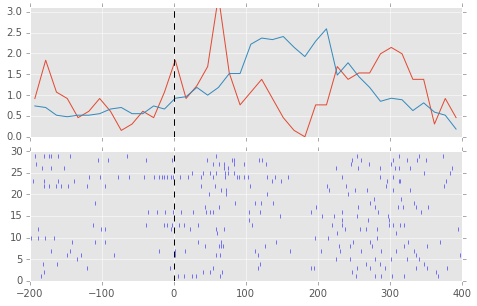

In [84]:
# plot a raster for a record, odor, concentration

sr_spikes = a_record['odor_resp']['spikes'][this_odor_conc,:]
sr_t0     = a_record['odor_resp']['t_0']

#plot the psth
sr_plot = plt.figure()
ras_ax  = sr_plot.add_axes([0, 0, 1, .45])
hist_ax = sr_plot.add_axes([0, .5, 1, .45])
t0 = 200
t1 = 0
t2= 600
bin_size=15

#plot the raster
lines,_ = plot_raster(sr_spikes,t0=t0,t1=t1,t2=t2,ax=ras_ax)
ras_ax.set_xlim(-t0,t2-t0)

#the psth
hist_line, hist_ax = plot_raster(sr_spikes,t0=t0, t1=t1,t2=t2, bin_size=bin_size, ax=hist_ax)
#hist_ax.set_ylim(0.9,1.1)
hist_ax.set_xlim(-t0,t2-t0)
hist_ax.set_xticklabels([])

#the baseline
#get the baseline for the cell
bl_spikes = baselines[a_record['meta']['id']]['spikes']
bl_t0     = baselines[a_record['meta']['id']]['t_0']
t1=300
t0=200
t2=900
base_line, hist_ax = plot_raster(bl_spikes,t0=t0, t1=t1,t2=t2, bin_size=bin_size, ax=hist_ax)

In [79]:
a_record['meta']['id']

'ZKawakeM72_020_c_022'